## Fixed Income Factors

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import edhec_risk_kit_206 as erk1
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
from datetime import date
from pandas_datareader import data
import work as work
import pandas_datareader.data as web
import quantstats as qs
import fixed_income_factors as fif

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining the Function for Fixed Income Factors Backtest

1. Requires Real Yields of All Securities & Total Return Indices of the same as Raw Data
2. Input Parameters
   
   > Number of Top Scoring Securities to go buy (Max Top 3, weighted equally)
   
   > Sample Period Start Date & End Date
   
   > "Yes" for Long/Short and "No" for Long Only Backtest Results for input variable long_short
   
3. Specific to Value Factor
   
   > Lookback Period for Real Yields Z-Score Calculation (in Years)
   
   > Lookback Period for Smoothening Z-Score (in Days) to avoid timing luck factor
   
4. Specific to Momentum Factor
   
   > Lookback Period for Momentum in Total Return Bond Indices (in Days)

In [3]:
import quandl
quandl.ApiConfig.api_key = 'KZ69tzkHfXscfQ1qcJ5K'

## Raw Data Gathering
1. Bond Total Return Indices
2. Effective Yields of Bond Indices
3. Inflation Expectations

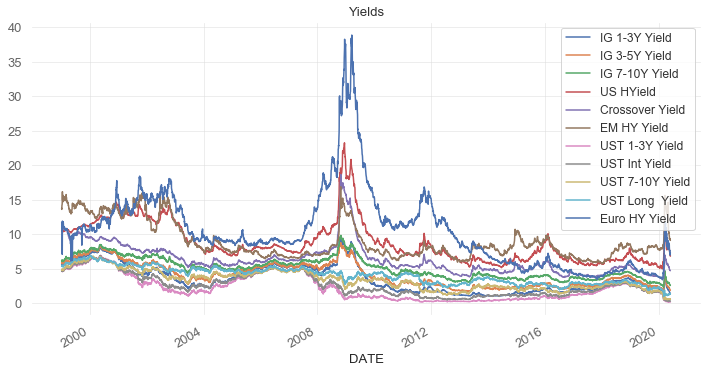

In [4]:
#Expected Inflation Data from Cleveland Fed
infl = pd.read_excel('expected_inflation_rates.xlsx', index_col=0, header=0, parse_dates=True)
infl.index.name = 'DATE'
yields = pd.read_excel('fi_yields.xlsx', header=0, index_col=0, parse_dates=True)
yields.dropna(inplace=True)
yields.index.name = 'DATE'
data = infl.merge(yields, on='DATE')
yields.plot(figsize=(12,6), fontsize=13, title='Yields')

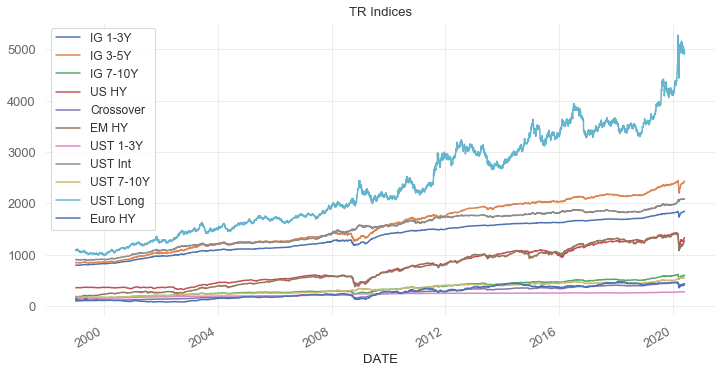

In [5]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
indices.plot(figsize=(12,6), fontsize=13, title='TR Indices')

infl = pd.read_excel('expected_inflation_rates.xlsx', index_col=0, header=0, parse_dates=True)
infl.index.name = 'DATE'
data = infl.merge(yields, on='DATE')
data.dropna(inplace=True)

## Real Yields Calculation

In [6]:
ig1_3ry = pd.DataFrame(data['IG 1-3Y Yield'] - data[' 2 year Expected Inflation'])
ig3_5ry = pd.DataFrame(data['IG 3-5Y Yield'] - data[' 4 year Expected Inflation'])
ig7_10ry = pd.DataFrame(data['IG 7-10Y Yield'] - data[' 8 year Expected Inflation'])
us_hyry = pd.DataFrame(data['US HYield'] - data[' 4 year Expected Inflation'])
crossry = pd.DataFrame(data['Crossover Yield'] - data[' 4 year Expected Inflation'])
em_hyry = pd.DataFrame(data['EM HY Yield'] - data[' 8 year Expected Inflation'])
ust1_3ry = pd.DataFrame(data['UST 1-3Y Yield'] - data[' 2 year Expected Inflation'])
ust_intry = pd.DataFrame(data['UST Int Yield'] - data[' 4 year Expected Inflation'])
ust7_10ry = pd.DataFrame(data['UST 7-10Y Yield'] - data[' 8 year Expected Inflation'])
ust_longry = pd.DataFrame(data['UST Long  Yield'] - data[' 24 year Expected Inflation'])
euro_hyry = pd.DataFrame(data['Euro HY Yield'] - data[' 4 year Expected Inflation'])

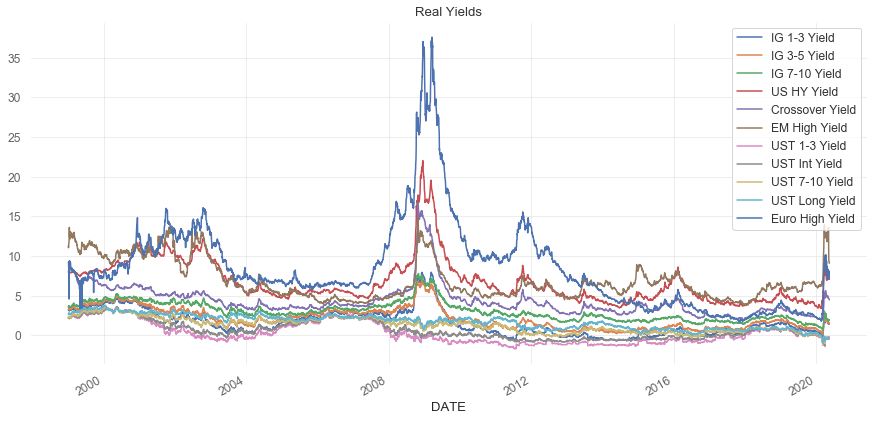

In [7]:
real_yields = ig1_3ry.merge(ig3_5ry, on='DATE').merge(ig7_10ry, on='DATE').merge(us_hyry, on='DATE').merge(crossry, on='DATE').merge(em_hyry, on='DATE').merge(ust1_3ry, on='DATE').merge(ust_intry, on='DATE').merge(ust7_10ry, on='DATE').merge(ust_longry, on='DATE').merge(euro_hyry, on='DATE')
real_yields.dropna(inplace=True)
real_yields.columns = ['IG 1-3 Yield', 'IG 3-5 Yield', 'IG 7-10 Yield', 'US HY Yield', 'Crossover Yield', 'EM High Yield', 'UST 1-3 Yield', 'UST Int Yield', 'UST 7-10 Yield', 'UST Long Yield', 'Euro High Yield']
real_yields.plot(figsize=(15,7), title='Real Yields')

### Defining the Function for Fixed Income Factors Backtest

1. Requires Real Yields of All Securities & Total Return Indices of the same as Raw Data
2. Input Parameters
   
   > Number of Top Scoring Securities to go buy (Max Top 3, weighted equally)
   
   > Sample Period Start Date & End Date
   
   > "Yes" for Long/Short and "No" for Long Only Backtest Results for input variable long_short
   
3. Specific to Value Factor
   
   > Lookback Period for Real Yields Z-Score Calculation (in Years)
   
   > Lookback Period for Smoothening Z-Score (in Days) to avoid timing luck factor
   
4. Specific to Momentum Factor
   
   > Lookback Period for Momentum in Total Return Bond Indices (in Days)

## Generate Portfolio Tearsheet to compare with a benchmark i.e. Equally Weighted of all the above securities

In [8]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)

In [13]:
import fixed_income_factors as fif
#Inputs

zscore_lookback = 7       #Number of Years
z_score_smoothening=500   #Number of Days
n_securities=3            #Number of Securities for Long only or Long/Short Portfolio
long_short='No'          #Long/Short or Long/Only as Output
duration_adj = 'Yes'
sample_start='2003'       #Start of Sample Period
sample_end='2015'         #End of Sample Period

#Momentum
lookback_period = 63     #Quarterly Returns as lookback 

In [14]:
momentum_factor  = fif.momentum_factor_backtest(indices, lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end)

C:\Users\Harsh\Desktop\EDHEC Risk\Course 2 - Advanced\fixed_income_factors.py:202: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
def momentum_interactive(lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end):
    indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
    indices.dropna(inplace=True)
    momentum_factor  = fif.momentum_factor_backtest(indices, lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end)
    return fif.plot_chart(momentum_factor[['EW', 'Momentum Factor', 'US HY', 'EM HY']], sample_start=sample_start, sample_end=sample_end, long_short=long_short, factor_name = 'Momentum')

    
interact(momentum_interactive,lookback_period = (21, 756, 21),
                         duration_adj = list(['Yes', 'No']), n_securities = (1,3,1),
                         long_short= list(['No', 'Yes']), 
                         sample_start = widgets.DatePicker(value=pd.to_datetime('01-Jan-2003')),
                         sample_end = widgets.DatePicker(value=pd.to_datetime('31-Dec-2015')))

interactive(children=(IntSlider(value=378, description='lookback_period', max=756, min=21, step=21), Dropdown(…

<function __main__.momentum_interactive(lookback_period, duration_adj, n_securities, long_short, sample_start, sample_end)>

In [15]:
erk.summary_stats1(momentum_factor,0,252).sort_values('Total Return').T

,UST 1-3YM,UST IntM,IG 1-3YM,IG 3-5YM,UST 7-10YM,IG 7-10YM,EW,UST Long M,CrossoverM,US HYM,EM HYM,Euro HYM,Momentum Factor
Total Return,32.95,53.40,55.71,78.82,88.77,103.03,114.57,126.24,126.37,173.57,243.17,247.42,355.97
Annualized Return,2.29,3.46,3.58,4.72,5.17,5.79,6.26,6.70,6.71,8.34,10.33,10.43,12.83
Annualized Vol,1.41,3.26,1.70,3.32,6.81,5.95,3.71,11.96,4.18,4.89,6.41,11.56,4.58
Skewness,-0.08,0.04,-1.46,-0.46,0.06,-0.34,-0.54,-0.03,-2.58,-1.70,-1.43,-0.12,0.22
Kurtosis,13.42,7.38,28.35,8.17,5.90,7.08,8.51,4.66,38.70,34.10,23.83,7.86,7.75
Cornish-Fisher VaR (5%),0.12,0.30,0.15,0.33,0.65,0.60,0.37,1.19,0.38,0.41,0.60,1.11,0.38
Historic CVaR (5%),0.19,0.45,0.25,0.48,0.94,0.86,0.53,1.68,0.65,0.77,1.00,1.65,0.62
Sharpe Ratio,1.62,1.06,2.10,1.42,0.76,0.97,1.69,0.56,1.60,1.70,1.61,0.90,2.80
Sortino Ratio,34.89,24.83,36.06,30.15,18.27,21.60,35.67,13.30,24.87,26.56,27.00,19.77,62.65
Max Drawdown,-2.17,-4.48,-8.06,-11.89,-10.22,-20.87,-17.05,-18.40,-32.19,-34.99,-35.91,-47.20,-6.12


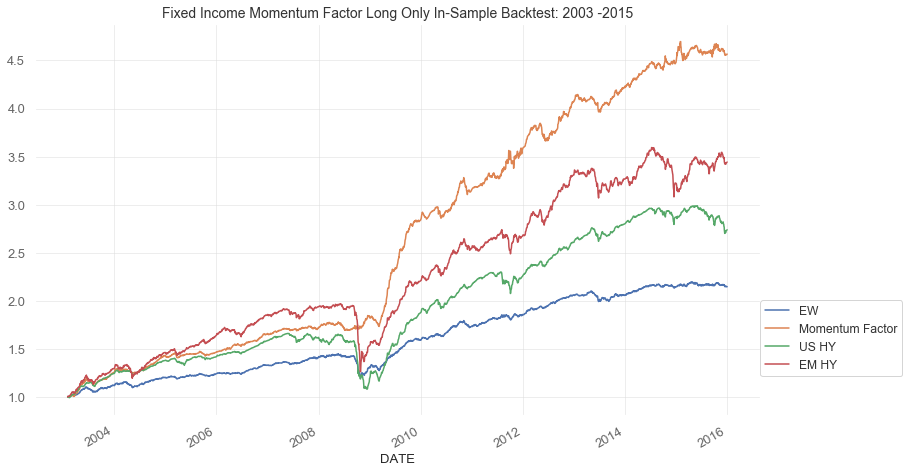

In [17]:
fif.plot_chart(momentum_factor[['EW', 'Momentum Factor', 'US HY', 'EM HY']], sample_start='2003', sample_end='2015', long_short='No', factor_name = 'Momentum')

In [83]:
qs.reports.html(momentum_factor['Momentum Strategy'], momentum_factor['EW'], output='Momentum.html', title='Momentum Factor Tearsheet')
import webbrowser
new = 2
url = "Momentum.html"
webbrowser.open(url,new=new)

True

## Value

In [676]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)

In [677]:
value_factor  = fif.value_factor_backtest(real_yields, indices, zscore_lookback, z_score_smoothening, n_securities, long_short, sample_start, sample_end)

C:\Users\Harsh\Desktop\EDHEC Risk\Course 2 - Advanced\fixed_income_factors.py:285: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [678]:
erk.summary_stats1(value_factor,0,252).sort_values('Total Return').T

,UST 1-3Y,UST Int,IG 1-3Y,IG 3-5Y,UST 7-10Y,EW,Crossover,Euro HY,IG 7-10Y,UST Long,US HY,EM HY,Value Factor
Total Return,11.75,25.33,27.23,44.82,47.86,51.02,56.91,57.19,62.06,68.88,72.20,80.19,130.42
Annualized Return,1.53,3.13,3.34,5.18,5.49,5.78,6.33,6.36,6.79,7.42,7.65,8.34,12.09
Annualized Vol,1.24,3.31,1.74,3.31,7.34,3.89,5.03,12.84,6.23,13.86,5.89,7.16,5.36
Skewness,-0.12,0.12,-2.05,-0.62,0.14,-0.72,-2.50,-0.13,-0.41,-0.01,-1.62,-1.59,-0.20
Kurtosis,26.66,9.02,40.45,10.67,6.16,9.94,31.50,7.93,8.34,4.04,27.51,24.88,7.64
Cornish-Fisher VaR (5%),0.09,0.30,0.14,0.33,0.69,0.39,0.50,1.25,0.62,1.39,0.55,0.69,0.50
Historic CVaR (5%),0.16,0.46,0.26,0.49,1.01,0.58,0.84,1.89,0.91,1.87,0.98,1.15,0.77
Sharpe Ratio,1.23,0.95,1.92,1.57,0.75,1.49,1.26,0.50,1.09,0.54,1.30,1.17,2.26
Sortino Ratio,25.31,22.01,29.19,31.42,18.23,29.77,18.82,10.67,23.23,13.19,19.82,18.70,47.68
Max Drawdown,-0.96,-4.48,-8.06,-10.82,-10.22,-15.89,-31.28,-44.19,-17.85,-18.40,-32.13,-35.30,-12.74


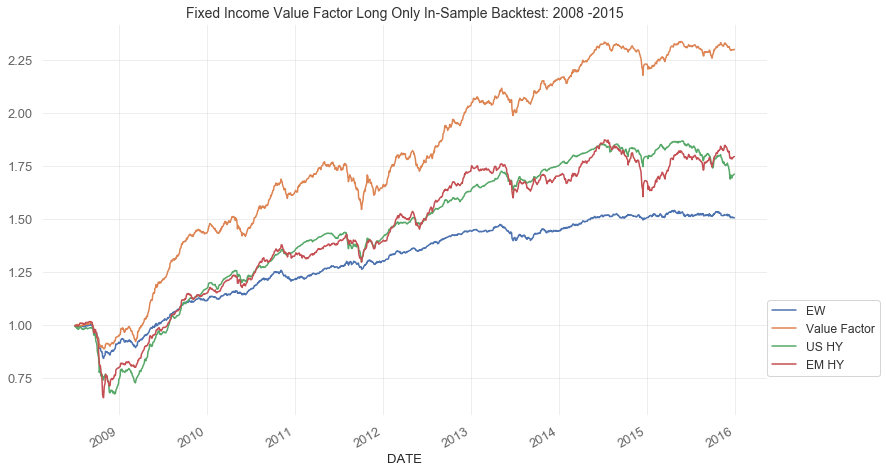

In [681]:
fif.plot_chart(value_factor[['EW', 'Value Factor', 'US HY', 'EM HY']], sample_start='2008', sample_end='2015', long_short='No', factor_name = 'Value')

In [99]:
qs.reports.html(value_factor['Value Strategy'], value_factor['EW'], output='Value.html', title='Value Factor Tearsheet')
import webbrowser
new = 2
url = "Value.html"
webbrowser.open(url,new=new)

True

## Trend Filtered Value Factor

In [683]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)
lookback_period=63

In [684]:
trend_value_factor  = fif.trend_value_factor_backtest(real_yields, indices, zscore_lookback, lookback_period, z_score_smoothening, sample_start, sample_end)

C:\Users\Harsh\Desktop\EDHEC Risk\Course 2 - Advanced\fixed_income_factors.py:366: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [685]:
erk.summary_stats1(trend_value_factor,0,252).sort_values('Total Return').T

,UST 1-3Y,UST Int,IG 1-3Y,IG 3-5Y,UST 7-10Y,EW,Crossover,Euro HY,IG 7-10Y,UST Long,US HY,EM HY,Trend Value Factor
Total Return,11.75,25.33,27.23,44.82,47.86,51.02,56.91,57.19,62.06,68.88,72.20,80.19,102.31
Annualized Return,1.53,3.13,3.34,5.18,5.49,5.78,6.33,6.36,6.79,7.42,7.65,8.34,10.11
Annualized Vol,1.24,3.31,1.74,3.31,7.34,3.89,5.03,12.84,6.23,13.86,5.89,7.16,9.24
Skewness,-0.12,0.12,-2.05,-0.62,0.14,-0.72,-2.50,-0.13,-0.41,-0.01,-1.62,-1.59,0.11
Kurtosis,26.66,9.02,40.45,10.67,6.16,9.94,31.50,7.93,8.34,4.04,27.51,24.88,8.78
Cornish-Fisher VaR (5%),0.09,0.30,0.14,0.33,0.69,0.39,0.50,1.25,0.62,1.39,0.55,0.69,0.83
Historic CVaR (5%),0.16,0.46,0.26,0.49,1.01,0.58,0.84,1.89,0.91,1.87,0.98,1.15,1.40
Sharpe Ratio,1.23,0.95,1.92,1.57,0.75,1.49,1.26,0.50,1.09,0.54,1.30,1.17,1.09
Sortino Ratio,25.31,22.01,29.19,31.42,18.23,29.77,18.82,10.67,23.23,13.19,19.82,18.70,22.28
Max Drawdown,-0.96,-4.48,-8.06,-10.82,-10.22,-15.89,-31.28,-44.19,-17.85,-18.40,-32.13,-35.30,-11.54


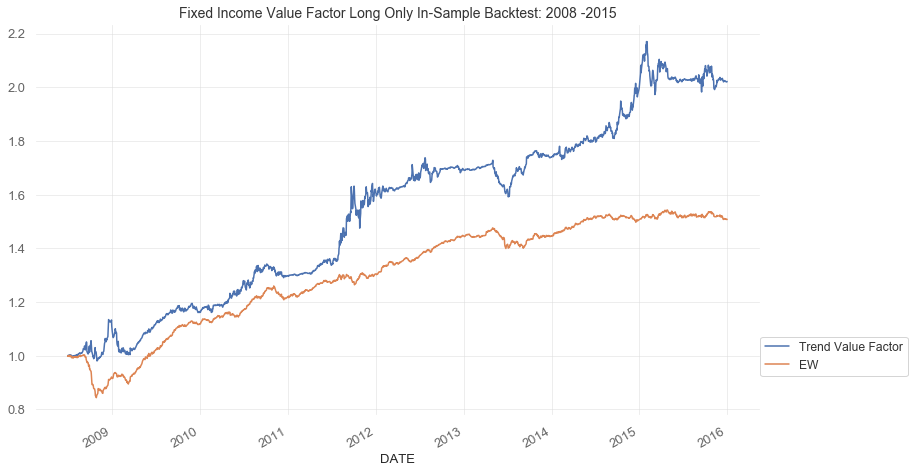

In [686]:
fif.plot_chart(trend_value_factor[['Trend Value Factor','EW']], sample_start='2008', sample_end='2015', long_short='No', factor_name = 'Value')

## Low Volatility Factor Backtest

In [753]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)

In [754]:
n_securities=3            #Number of Securities for Long only or Long/Short Portfolio
long_short='No'           #Long/Short or Long/Only as Output
sample_start='1999'       #Start of Sample Period
sample_end='2015'         #End of Sample Period
lookback_period = 21      #Quarterly Returns as lookback 

In [755]:
volatility_factor  = fif.volatility_factor_backtest(real_yields,indices, lookback_period, n_securities, long_short, sample_start, sample_end)

C:\Users\Harsh\Desktop\EDHEC Risk\Course 2 - Advanced\fixed_income_factors.py:429: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [756]:
#volatility_factor  = fif.volatility_factor_backtest(real_yields.drop(['UST 1-3 Yield', 'UST Int Yield','UST 7-10 Yield','UST Long Yield'],axis=1),indices.drop(['UST 1-3Y','UST Int','UST 7-10Y','UST Long '],axis=1), lookback_period, n_securities, long_short, sample_start, sample_end)

In [757]:
erk.summary_stats1(volatility_factor,0,252).sort_values('Total Return').T

,UST 1-3Y,UST Int,IG 1-3Y,IG 3-5Y,UST 7-10Y,IG 7-10Y,US HY,EW,Euro HY,UST Long,Crossover,Low Volatility Factor,EM HY
Total Return,70.00,102.62,103.97,141.67,158.44,174.80,179.98,182.85,213.28,216.73,237.75,407.68,458.12
Annualized Return,3.28,4.38,4.43,5.51,5.91,6.31,6.46,6.52,7.16,7.21,7.72,10.38,11.06
Annualized Vol,1.48,3.23,1.74,3.36,6.67,5.96,4.77,3.84,17.45,11.38,3.89,5.09,7.27
Skewness,0.19,0.04,-1.03,-0.35,0.00,-0.32,-2.23,-0.34,1.79,-0.08,-2.61,-0.48,-1.01
Kurtosis,13.40,7.38,21.77,7.31,5.70,6.29,39.45,10.53,135.63,4.74,40.66,7.26,16.82
Cornish-Fisher VaR (5%),0.12,0.30,0.15,0.33,0.64,0.60,0.41,0.36,-1.79,1.14,0.34,0.50,0.71
Historic CVaR (5%),0.20,0.45,0.25,0.48,0.93,0.85,0.76,0.54,2.06,1.62,0.60,0.73,1.15
Sharpe Ratio,2.21,1.35,2.55,1.64,0.89,1.06,1.35,1.70,0.41,0.63,1.99,2.04,1.52
Sortino Ratio,48.80,31.59,46.68,35.59,21.10,23.83,20.88,35.89,7.80,14.84,30.69,43.55,26.74
Max Drawdown,-2.17,-4.48,-8.06,-11.89,-10.22,-20.87,-34.99,-17.05,-47.20,-18.40,-32.19,-19.29,-35.91


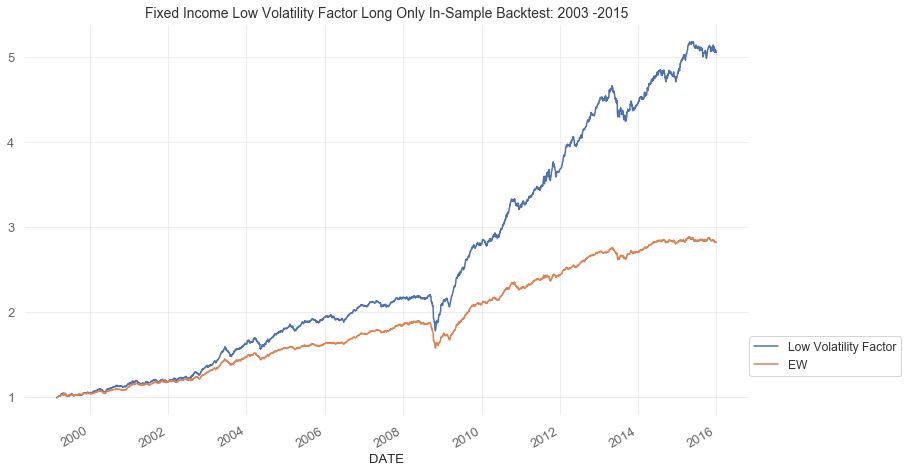

In [758]:
fif.plot_chart(volatility_factor[['Low Volatility Factor', 'EW']], sample_start='2003', sample_end='2015', long_short='No', factor_name = 'Low Volatility')

In [140]:
qs.reports.html(volatility_factor['Low Volatility Strategy'], volatility_factor['EW'], output='Volatility.html', title='Low Volatility Factor Tearsheet')
import webbrowser
new = 2
url = "Volatility.html"
webbrowser.open(url,new=new)

True

## Carry Strategy Backtest

In [ ]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)

In [147]:
n_securities=3            #Number of Securities for Long only or Long/Short Portfolio
long_short='No'           #Long/Short or Long/Only as Output
sample_start='1999'       #Start of Sample Period
sample_end='2015'         #End of Sample Period
smoothening_period = 1

In [148]:
carry_factor  = fif.carry_factor_backtest(yields, indices, smoothening_period, n_securities, long_short, sample_start, sample_end)

C:\Users\Harsh\Desktop\EDHEC Risk\Course 2 - Advanced\fixed_income_factors.py:452: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [149]:
erk.summary_stats1(carry_factor,0,252).sort_values('Total Return').T

,UST 1-3,UST Int,IG 1-3,IG 3-5,UST 7-10,IG 7-10,US HY,EW,UST Long,Euro HY,Crossover,Carry Strategy,EM HY
Total Return,69.14,99.59,103.52,138.69,149.21,166.68,177.64,178.38,201.55,204.50,240.81,293.16,459.23
Annualized Return,3.23,4.27,4.40,5.40,5.65,6.09,6.38,6.40,6.85,6.95,7.75,8.69,11.11
Annualized Vol,1.48,3.23,1.74,3.36,6.67,5.97,4.77,3.84,11.38,17.41,3.88,7.26,7.29
Skewness,0.19,0.04,-1.03,-0.35,0.00,-0.32,-2.23,-0.34,-0.08,1.80,-2.60,0.03,-0.99
Kurtosis,13.37,7.37,21.71,7.29,5.68,6.27,39.55,10.50,4.73,136.06,40.63,58.45,16.67
Cornish-Fisher VaR (5%),0.12,0.30,0.15,0.33,0.65,0.60,0.41,0.36,1.14,-1.80,0.34,0.20,0.71
Historic CVaR (5%),0.20,0.45,0.25,0.48,0.93,0.86,0.76,0.54,1.62,2.05,0.60,1.01,1.15
Sharpe Ratio,2.18,1.32,2.53,1.60,0.85,1.02,1.34,1.67,0.60,0.40,2.00,1.20,1.52
Sortino Ratio,48.19,30.82,46.37,34.89,20.20,22.98,20.70,35.27,14.10,7.60,30.89,21.62,26.88
Max Drawdown,-2.17,-4.48,-8.06,-11.89,-10.22,-20.87,-34.99,-17.05,-18.40,-47.20,-32.19,-36.15,-35.91


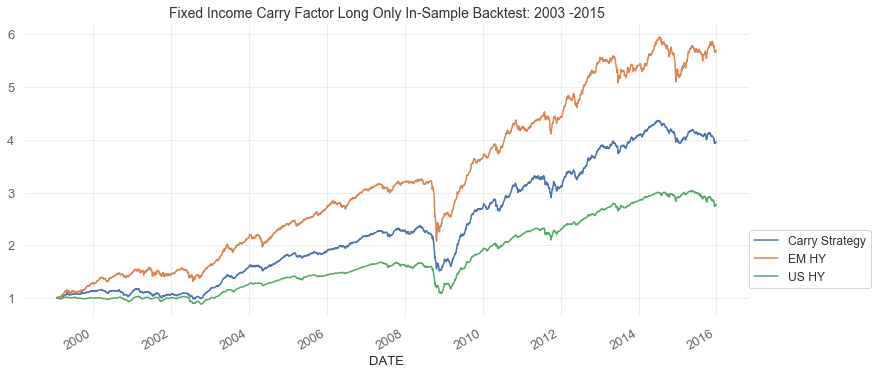

In [151]:
fif.plot_chart(carry_factor[['Carry Strategy', 'EM HY', 'US HY']], sample_start='2003', sample_end='2015', long_short='No', factor_name = 'Carry')

## EW Composite

In [759]:
factors = pd.DataFrame(value_factor['Value Factor']).merge(volatility_factor['Low Volatility Factor'], on='DATE').merge(pd.DataFrame(momentum_factor), on='DATE')
factors['EW Composite'] = factors[['Value Factor', 'Momentum Factor', 'Low Volatility Factor']].mean(axis=1)

## Factor Correlations

In [760]:
factors[['Value Factor', 'Momentum Factor', 'Low Volatility Factor', ]].corr().round(4)*100

,Value Factor,Momentum Factor,Low Volatility Factor
Value Factor,100.00,38.20,57.24
Momentum Factor,38.20,100.00,47.24
Low Volatility Factor,57.24,47.24,100.00


In [761]:
erk.summary_stats1(factors,0,252).sort_values('Total Return').T

,UST 1-3Y,UST Int,IG 1-3Y,IG 3-5Y,UST 7-10Y,EW,Crossover,Euro HY,IG 7-10Y,UST Long,US HY,EM HY,Value Factor,Low Volatility Factor,EW Composite,Momentum Factor
Total Return,11.75,25.33,27.23,44.82,47.86,51.02,56.91,57.19,62.06,68.88,72.20,80.19,130.42,134.55,144.04,165.97
Annualized Return,1.53,3.13,3.34,5.18,5.49,5.78,6.33,6.36,6.79,7.42,7.65,8.34,12.09,12.34,12.95,14.28
Annualized Vol,1.24,3.31,1.74,3.31,7.34,3.89,5.03,12.84,6.23,13.86,5.89,7.16,5.36,5.61,4.33,5.12
Skewness,-0.12,0.12,-2.05,-0.62,0.14,-0.72,-2.50,-0.13,-0.41,-0.01,-1.62,-1.59,-0.20,-0.67,-0.28,0.17
Kurtosis,26.66,9.02,40.45,10.67,6.16,9.94,31.50,7.93,8.34,4.04,27.51,24.88,7.64,8.42,6.70,7.07
Cornish-Fisher VaR (5%),0.09,0.30,0.14,0.33,0.69,0.39,0.50,1.25,0.62,1.39,0.55,0.69,0.50,0.56,0.40,0.43
Historic CVaR (5%),0.16,0.46,0.26,0.49,1.01,0.58,0.84,1.89,0.91,1.87,0.98,1.15,0.77,0.84,0.59,0.69
Sharpe Ratio,1.23,0.95,1.92,1.57,0.75,1.49,1.26,0.50,1.09,0.54,1.30,1.17,2.26,2.20,2.99,2.79
Sortino Ratio,25.31,22.01,29.19,31.42,18.23,29.77,18.82,10.67,23.23,13.19,19.82,18.70,47.68,43.50,66.24,62.07
Max Drawdown,-0.96,-4.48,-8.06,-10.82,-10.22,-15.89,-31.28,-44.19,-17.85,-18.40,-32.13,-35.30,-12.74,-19.29,-10.73,-6.12


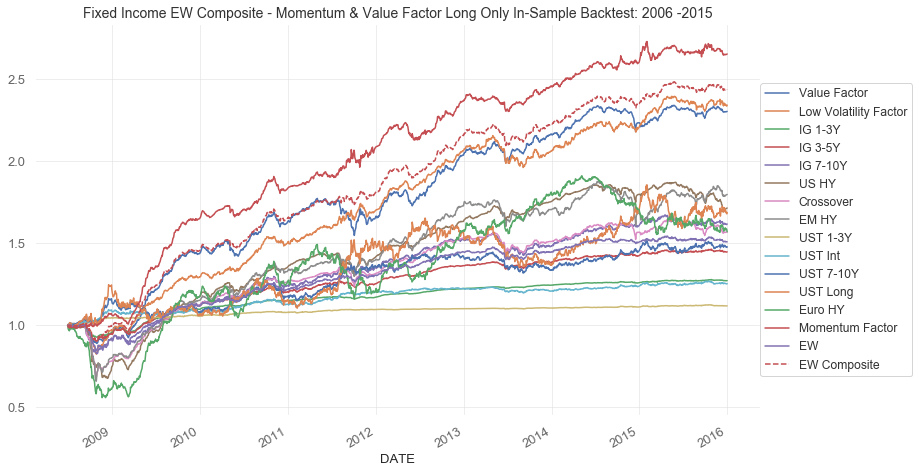

In [762]:
fif.plot_chart(factors.drop(['EW Composite'],axis=1), sample_start='2006', sample_end='2015', long_short='No', factor_name = 'EW Composite - Momentum & Value')
(1+factors['EW Composite']).cumprod().plot(style='--', color='r')
plt.legend(loc=(1,0.1))

In [763]:
spy = yf.download('SPY')['Adj Close']
spy=pd.DataFrame(spy)
spy.columns = ['SPY']

[*********************100%***********************]  1 of 1 completed


In [767]:
qs.reports.html(factors['EW Composite']['2009-05':], spy.pct_change().dropna() , output='Composite.html', title='EW Composite (Momentum, Value, Volatility) Factor Tearsheet')
import webbrowser
new = 2
url = "Composite.html"
webbrowser.open(url,new=new)

True

## VIX Switching Strategy

>  Uses VIX level as a percentile of the past lookback period to decide allocation between High Duration US Treasuries and Emerging Market USD HY Bonds 

In [ ]:
col = indices.columns

In [181]:
indices = pd.read_excel('fi_prices.xlsx', header=0, index_col=0, parse_dates=True)
indices.dropna(inplace=True)

In [182]:
duration = indices[['UST Int', 'UST 7-10Y', 'UST Long ']]
high_yield = indices[['US HY', 'EM HY', 'Crossover', 'Euro HY']]

In [183]:
vix_model = fif.fi_vix_allocator(duration, high_yield, 5, 7, '2015')

[*********************100%***********************]  1 of 1 completed


In [184]:
erk.summary_stats1(vix_model,0,252).sort_values('Total Return').T

,UST Int,UST 7-10Y,Crossover,UST Long,US HY,Euro HY,EM HY,Portfolio
Total Return,48.78,81.34,99.63,114.87,116.77,140.07,166.16,169.94
Annualized Return,3.48,5.26,6.13,6.80,6.88,7.81,8.77,8.92
Annualized Vol,3.24,6.76,4.26,12.06,5.01,11.58,6.38,4.28
Skewness,0.06,0.10,-2.62,-0.01,-1.68,-0.15,-1.53,-0.10
Kurtosis,7.84,6.20,38.84,4.73,33.49,8.08,25.83,8.21
Cornish-Fisher VaR (5%),0.30,0.64,0.39,1.20,0.43,1.12,0.60,0.39
Historic CVaR (5%),0.45,0.94,0.67,1.69,0.80,1.67,1.00,0.61
Sharpe Ratio,1.08,0.78,1.44,0.56,1.38,0.67,1.37,2.08
Sortino Ratio,25.06,18.71,22.15,13.38,21.48,14.60,22.64,44.97
Max Drawdown,-4.48,-10.22,-32.19,-18.44,-34.99,-47.20,-35.91,-6.99


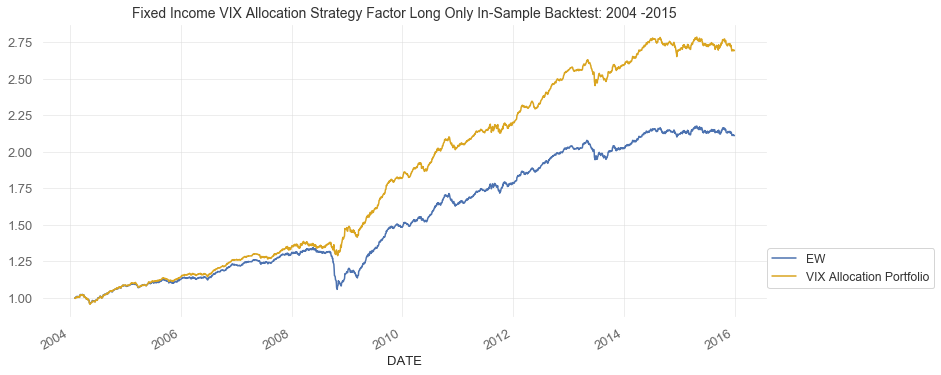

In [185]:
fif.plot_chart(vix_model.drop(['Portfolio'], axis=1).mean(axis=1), sample_start='2004', sample_end='2015', long_short='No', factor_name = 'VIX Allocation Strategy')
(1+vix_model['Portfolio']).cumprod().plot(color='goldenrod')
plt.legend(['EW', 'VIX Allocation Portfolio'],loc=(1,0.1))

In [209]:
qs.reports.html(vix_model['Portfolio'], vix_model.drop(['Portfolio'], axis=1).mean(axis=1), output='VIX_Model.html', title='VIX Allocation Model Tearsheet')
import webbrowser
new = 2
url = "VIX_Model.html"
webbrowser.open(url,new=new)

True

## Interactive Paramter Sensitivity Testing

In [186]:
import ipywidgets as widgets
from IPython.display import display

In [191]:
def show_vix_model(lookback_period, smoothening_period):
    vix_model = fif.fi_vix_allocator(duration, high_yield, lookback_period, smoothening_period, '2015')
    fif.plot_chart(vix_model.drop(['Portfolio'], axis=1).mean(axis=1), sample_start='2004', sample_end='2015', long_short='No', factor_name = 'VIX Allocation Strategy')
    b = (1+vix_model['Portfolio']).cumprod().plot(color='goldenrod')
    plt.legend(['EW', 'VIX Allocation Portfolio'],loc=(1,0.1))
    b.annotate("Annualized Return(CAGR): "+str((erk.annualized_ret(vix_model["Portfolio"], 252)*100).round(2)) +"%", xy=(.05, .90), xycoords='axes fraction', fontsize=14)
    #b.annotate("Annualized Volatility(Daily): "+str((erk.annualized_vol(vix_model["Portfolio"], 252)*100)) +"%", xy=(.05, .85), xycoords='axes fraction', fontsize=14)
    b.annotate("Sharpe Ratio: "+str(erk.sharpe_ratio(vix_model["Portfolio"], 252, 0.0).round(2)), xy=(.05, .85), xycoords='axes fraction', fontsize=14)

In [192]:
model_controls = widgets.interactive(show_vix_model,
                                   lookback_period = widgets.IntSlider(min=1, max=10, step=1, value=5, description="Lookback Period (Yrs)",style = {'description_width': '200px'}, layout = {'width': '400px'}),
                                   smoothening_period = widgets.IntSlider(min=1, max=15, step=1, value=7, description="Smoothening Period (Days)",style = {'description_width': '200px'}, layout = {'width': '400px'}),
                                   )

In [193]:
display(model_controls)

interactive(children=(IntSlider(value=5, description='Lookback Period (Yrs)', layout=Layout(width='400px'), ma…